# Digit recognizer - A simple problem using neural network with Keras 
### ** Nguyen Dang Minh, PhD **

* [**1. Introduction**](#ch1)
* [**2. Data preparation**](#ch2)
    * [2.1 Import and visualize the data](#ch2.1)
    * [2.2 Preprocess the data](#ch2.2)
    * [2.3 Data augmentation](#ch2.3)
* [**3. Model construction**](#ch3)
* [**4. Visualize the results**](#ch4)
    

<a id="ch1"></a>

## 1. Introduction

This is the my first deep learning project after I have completed [Andrew Ng 's deep learning specialization](https://www.coursera.org/specializations/deep-learning).

The goal of the project is from a handwritten digit, the computer can tell which number it is. The dataset is taken from [Kaggle's Digit Recognizer competition](https://www.kaggle.com/c/digit-recognizer). This is a supervised classification problem whereas the input is an array containing pixel-by-pixel values of 28 $\times$ 28 images, and the output is one of ten digit values (0-9). There can be multiple approach to this problem. One can consider **clustering** (images of the same digits will belong to the same cluster). However, we will not be able to take full advantage of the training data (the label). One can also use classical classification algorithm, such as [SVM](http://scikit-learn.org/stable/modules/svm.html) or [Random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Before learning neural network, I did try solving this problem using SVM (see code [here](https://github.com/dmnguyen92/MNIST/blob/master/svm.py)). The code takes about 1.5 hour to run and can achieve accuracy up to **97%**. Imagine your friend from Singapore writes you his 8-digit phone number (relatively short compared to, say, Germany, 10 numbers). The chance of making the right prediction is 0.97$^8 \approx$ 78%. This is not a very good result.

This time I will use a more powerful tool that is built to deal with images data: a convolutional neural network (conv-net). The code is written using **Keras** with Tensorflow backend. The reason I chose Keras for this project is because it is quite intuitive (compared to **Tensorflow**) and has lots of community support (compared to **PyTorch**). With a relatively small network (2 convolutional layer, 2 dense layer), the performance can reach **99.1%** within 140s.

<table class='image'>
<img src="http://img1.imagilive.com/0717/mnist-sample.png" ></img>
<a id='fig1'><center> The MNIST dataset </center></a>
</table>

Here in Section 2 I will import, preprocess and augmented the data. The model is constructed in Section 3. The final section is for visualizing and analyzing the result. .


In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
import time

random.seed(1)

<a id="ch2"></a>

## 2. Data preparation

<a id="ch2.1"></a>

### 2.1 Import and visualize the data

In [7]:
dataset_orig = pd.read_csv('Data/train.csv')
select_idx = random.sample(range(0,len(dataset_orig)), 2200)
X_orig = dataset_orig.iloc[:,1:]
Y_orig = dataset_orig.iloc[:,0:1]

In [4]:
X_orig.shape

(42000, 784)

The independent variables have 42000 rows corresponding to 42000 training data. Each row is the pixel value (0-254) of a grayscale image with size of 28$\times$28 that has been flatten to a 1-d array

In [9]:
Y_orig.shape

(42000, 1)

Let us see if there is any data missing

In [5]:
X_orig.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
Y_orig.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

So there is no missing data. Next let's look at the data distribution

Text(0.5,1,'Training data disribution')

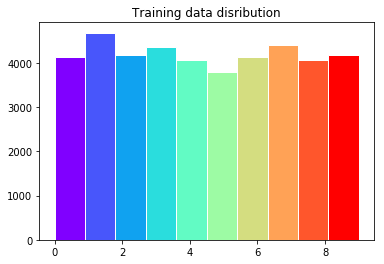

In [10]:
# This is to plot the data distribution
N, bins, patches = plt.hist(Y_orig.values, edgecolor='white')
colors = cm.rainbow(np.linspace(0, 1, len(patches)))
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
plt.title('Training data disribution')

<a id="ch2.2"></a>

### 2.2 Preprocess the data

The first step is to reshape the independent variables back to its image form and normalize it, then perform one-hot encoding on the label data.

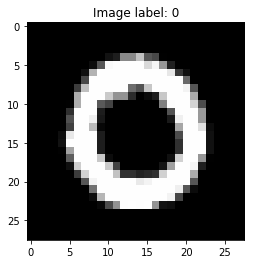

In [8]:
# Reshape and normalize
X_processed = X_orig.values.reshape(-1,28,28,1)
X_processed = X_processed/255.

# Show an example image
idx = 1
plt.imshow(X_processed[idx,:,:,0], cmap='gray')
plt.title('Image label: %i' %Y_orig.values[idx])

# One-hot encoding label data
Y_processed = to_categorical(Y_orig.values)

Next let's split the data into training and validation set. Here I use 90% for training and 10% for validation.

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_processed, Y_processed, test_size=0.1, random_state=1)

<a id="ch2.3"></a>

### 2.3 Data augmentation

One technique to improve the quality of the training set is to perform data augmentation, i.e. creating new input image by slightly rotate, shift or zoom-in the original one.

In [10]:
# Augment the data
train_datagen = ImageDataGenerator(rotation_range=15, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
train_datagen.fit(X_train)

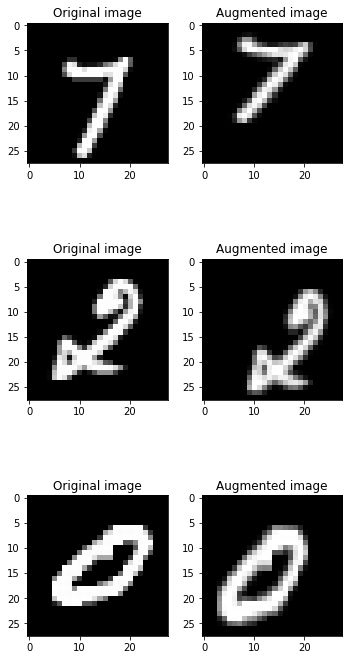

In [24]:
# Visualize the augmentation
fig = plt.figure(figsize=(5,10))
transform_list = random.sample(range(0,len(X_train)),3)
for i in range(3):
    idx = transform_list[i]
    ax = fig.add_subplot(3,2,i*2+1)
    plt.imshow(X_train[idx,:,:,0], cmap='gray')
    ax.set_title('Original image')
    
    ax = fig.add_subplot(3,2,i*2+2)
    plt.imshow(train_datagen.random_transform(X_train[idx,:,:,:])[:,:,0], cmap='gray')
    ax.set_title('Augmented image')
    
plt.tight_layout()

Here the images are augmented by rotating randomly within 15$^\circ$, shift vertically or horizontally up to 20% of the frame or zoom-in up to 20%.

<a id="ch3"></a>

## 3. Model construction

Here our model will consists of 2 convolutional layers to collect the graphical feature of the image, followed by 2 dense layer to do the classification job.

In [16]:
model = Sequential()

model.add(Conv2D(32,(5,5), padding='Same',activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
__________

The functionality of each layer:
* `Conv2D`: Run a convolutional windows throughout the image
* `Maxpool2D`: Within a certain window after convolution, pick the pixel with maximum value.  This step helps select important feature and reduce computational cost
* `Dropout`: A regularization layer to prevent overfitting
* `Flatten`: Flatten the result of the convolutional layer into 1-D array to serve as input for the `Dense` layer
* `Dense`: Fully connected neural network that performs the classification job

After building the model, the next step is to choose the criteria to fit the model into, and the corresponding optimization algorithm. Here we use `catergorical_crossentropy` as the lost function and `Adam` as the optimizer

In [17]:
optimizer = RMSprop()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Now is the time to train the model. The model will be trained with 30 epochs and batch size of 256

In [18]:
epochs = 30
batch_size = 256
time_start = time.time()
history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=int(len(X_train)/batch_size), epochs=epochs,
                              validation_data=(X_val, Y_val))
time_end = time.time()
print('Total run time %f seconds' %(time_end-time_start))

Epoch 1/30
147/147 [==============================] - 6s 39ms/step - loss: 1.4849 - acc: 0.4876 - val_loss: 0.4448 - val_acc: 0.8902
Epoch 2/30
147/147 [==============================] - 6s 39ms/step - loss: 0.8263 - acc: 0.7319 - val_loss: 0.2491 - val_acc: 0.9262
Epoch 3/30
147/147 [==============================] - 6s 42ms/step - loss: 0.5934 - acc: 0.8080 - val_loss: 0.1851 - val_acc: 0.9426
Epoch 4/30
147/147 [==============================] - 7s 49ms/step - loss: 0.4755 - acc: 0.8471 - val_loss: 0.1564 - val_acc: 0.9510
Epoch 5/30
147/147 [==============================] - 6s 41ms/step - loss: 0.4036 - acc: 0.8715 - val_loss: 0.1057 - val_acc: 0.9679
Epoch 6/30
147/147 [==============================] - 7s 45ms/step - loss: 0.3453 - acc: 0.8921 - val_loss: 0.0875 - val_acc: 0.9724
Epoch 7/30
147/147 [==============================] - 6s 42ms/step - loss: 0.3185 - acc: 0.8986 - val_loss: 0.0892 - val_acc: 0.9714
Epoch 8/30
147/147 [==============================] - 6s 39ms/step - 

<a id="ch4"></a>

## 4. Visualize the results

The model takes approximately 185 seconds to run and achieve the accuracy of 99%. This number will slightly change depending on the random state you choose when splitting the change/test set. Now let's see how the model's accuracy developes after each epochs.

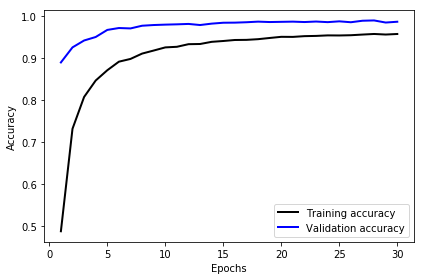

In [19]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epoch_step = np.linspace(1,epochs,epochs)

fig = plt.figure()
plt.plot(epoch_step, train_acc, linewidth=2, color='black', label='Training accuracy')
plt.plot(epoch_step, val_acc, linewidth=2, color='blue', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()

Now let us take a look at some example where the model gives the **wrong predictions**

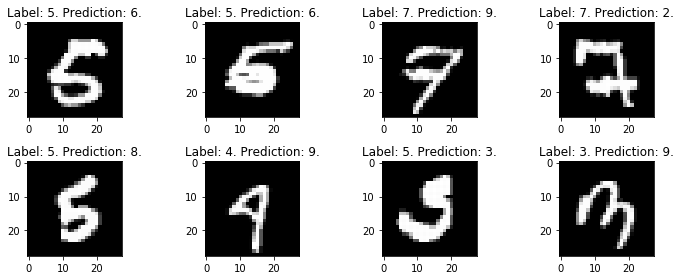

In [50]:
# Find out the index of the image where wrong prediction are made
Y_pred = model.predict(X_val)
Y_pred = Y_pred[:,:].argmax(axis=1)
Y_val_orig = Y_val[:,:].argmax(axis=1)
idx_error = np.where((Y_pred-Y_val_orig)!=0)

# Plot the error images
fig = plt.figure(figsize=(10,4))
for i in range(8):
    idx = idx_error[0][i]
    ax = fig.add_subplot(2,4,i+1)
    plt.imshow(X_val[idx,:,:,0], cmap='gray')
    ax.set_title('Label: %i. Prediction: %i.' %(Y_val_orig[idx], Y_pred[idx]))
    
plt.tight_layout()

In many of these examples, the hand-writting is strongly distorted and it is difficult even for human to make the right prediction.